In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('dayton_hourly.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour

df.drop(['Datetime'], axis=1, inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('DAYTON_MW', axis=1))

X = scaled_features
y = df['DAYTON_MW'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
import numpy as np

# Метрики расстояния
def minkowski_distance(x1, x2, p=2):
    return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

def cosine_distance(x1, x2):
    return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Ядерные функции
def uniform_kernel(distance):
    return np.array([1.0 if d <= 1 else 0.0 for d in distance])

def gaussian_kernel(distance):
    return np.exp(-(distance ** 2) / 2) / (np.sqrt(2 * np.pi))

def triangular_kernel(distance):
    return (1 - np.abs(distance)) * (distance < 1)

def epanechnikov_kernel(distance):
    return 3 / 4 * (1 - distance ** 2) * (distance < 1)

def general_kernel(u, x1, x2, alp):
    if u <= -1 or u >= 1:
        return 0
    return alp * (1 - abs(u) ** x1) ** x2

In [19]:
def regression_fixed_size_without_params(u, x_train, y_train, h, metric, kernel):
    distances = np.array([metric(u, xi) for xi in x_train])
    weights = np.array([kernel(d / h) for d in distances])
    if np.sum(weights) > 0:
        return np.dot(weights, y_train) / np.sum(weights)
    else:
        return np.mean(y_train)


In [20]:
h = 1
prediction = regression_fixed_size_without_params(X_test[0], X_train, y_train, h, euclidean_distance, gaussian_kernel)
print("Значение для 1го объекта тестовой выборки:", prediction)


Значение для 1го объекта тестовой выборки: 2236.9765669645312


In [21]:
def get_kth_nearest_distance(u, k, metric, x_train):
    distances = np.array([metric(u, xi) for xi in x_train])
    return np.partition(distances, k)[k]


def non_param_regression_non_fixed_size(u, x_train, y_train, k, metric, kernel):
    kth_distance = get_kth_nearest_distance(u, k, metric, x_train)
    weighted_values = np.array([kernel(metric(u, xi) / kth_distance) * yi for xi, yi in zip(x_train, y_train)])
    weights = np.array([kernel(metric(u, xi) / kth_distance) for xi in x_train])

    if np.sum(weights) > 0:
        return np.sum(weighted_values) / np.sum(weights)
    else:
        return np.mean(y_train)


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('DAYTON_MW', axis=1))

X = scaled_features
y = df['DAYTON_MW'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k = 5

predictions = np.array(
    [non_param_regression_non_fixed_size(u, X_train, y_train, k, euclidean_distance, gaussian_kernel) for u in
     tqdm(X_test, desc='Predicting')])

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"RMSE for non-parametric regression with k={k}: {rmse}")



Predicting: 100%|██████████| 24255/24255 [27:58:53<00:00,  4.15s/it]     

RMSE for non-parametric regression with k=5: 224.89330426582674


In [60]:
def get_n_nearest_objects(u, n, metric, d_train):
    nearest_neighbours = NearestNeighbors(n_neighbors=n, metric=metric).fit(d_train)
    distances, indices = nearest_neighbours.kneighbors([u], return_distance=True)
    return d_train[indices.flatten()]


def get_nth_nearest_object(u, n, metric, d_train):
    return get_n_nearest_objects(u, n + 1, metric, d_train)[-2]

u = X_test[0]
n = 3
nearest_objects = get_n_nearest_objects(u, n, 'euclidean', X_train)
nth_nearest_object = get_nth_nearest_object(u, n, 'euclidean', X_train)

print(f"{n} ближайших соседей для точки u:")
for i, obj in enumerate(nearest_objects, start=1):
    print(f"{i}: {obj}")
print()

print(f"{n}-й ближайший сосед для точки v:")
print(nth_nearest_object)


3 ближайших соседей для точки u:
1: [-1.78752807  1.58883003 -0.08215004 -1.37270231]
2: [-1.78752807  1.58883003  0.1450661  -1.37270231]
3: [-1.78752807  1.58883003  0.03145803 -1.51717378]

3-й ближайший сосед для точки v:
[-1.78752807  1.58883003  0.03145803 -1.51717378]


In [28]:
def knn_predict(X_train, Y_train, X_test, k, distance_metric='euclidean', kernel_function=None, h=None):
    result_labels = []
    distances = cdist(X_test, X_train, metric=distance_metric)

    for i, distance_vector in enumerate(distances):
        if h is None:
            k_nearest_indices = np.argsort(distance_vector)[:k]
        else:
            k_nearest_indices = np.where(distance_vector <= h)[0]
        k_nearest_distances = distance_vector[k_nearest_indices]
        k_nearest_labels = Y_train[k_nearest_indices]
        if kernel_function is not None:
            weights = kernel_function(k_nearest_distances / h if h is not None else k_nearest_distances)
        else:
            weights = np.ones(k_nearest_labels.shape)
        label = np.average(k_nearest_labels, weights=weights)
        result_labels.append(label)

    return result_labels


In [24]:
distance_metric = euclidean_distance
kernel_function = gaussian_kernel
k = 5
h = 1

predicted_labels = knn_predict(X_train, y_train, X_test, k, distance_metric, kernel_function, h)

for i, label in tqdm(enumerate(predicted_labels), total=len(predicted_labels), desc="Прогнозирование"):
    print(f"Прогноз для точки {i}: {label}")

for i, (real, predicted) in tqdm(enumerate(zip(y_test, predicted_labels)), total=len(y_test),
                                 desc="Сравнение реальных и прогнозируемых значений"):
    print(f"Реальное значение: {real}, Прогнозируемое значение: {predicted}, Разница: {real - predicted}")


Прогнозирование: 100%|██████████| 24255/24255 [00:00<00:00, 231845.42it/s]


Прогноз для точки 0: 2239.5294940989797
Прогноз для точки 1: 1780.6287718916892
Прогноз для точки 2: 2034.4187789415118
Прогноз для точки 3: 2095.687034942959
Прогноз для точки 4: 2005.6171260092394
Прогноз для точки 5: 2239.261753580167
Прогноз для точки 6: 2219.676072905579
Прогноз для точки 7: 2203.6899472946093
Прогноз для точки 8: 1733.512431715704
Прогноз для точки 9: 2126.252075093255
Прогноз для точки 10: 2115.40313410858
Прогноз для точки 11: 1982.6566437991537
Прогноз для точки 12: 2059.2146425170995
Прогноз для точки 13: 1716.0828409700723
Прогноз для точки 14: 2068.7505359259735
Прогноз для точки 15: 1910.2876173567404
Прогноз для точки 16: 2221.6511229910875
Прогноз для точки 17: 1990.5217035570442
Прогноз для точки 18: 2217.269043311819
Прогноз для точки 19: 1773.1526112456602
Прогноз для точки 20: 1968.0797953517401
Прогноз для точки 21: 1690.6708206899002
Прогноз для точки 22: 2120.1029602065455
Прогноз для точки 23: 1715.9671013117359
Прогноз для точки 24: 2038.2888612

Сравнение реальных и прогнозируемых значений:   0%|          | 0/24255 [00:00<?, ?it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Сравнение реальных и прогнозируемых значений: 100%|██████████| 24255/24255 [00:00<00:00, 151622.14it/s]

Реальное значение: 3290.0, Прогнозируемое значение: 2479.0907106909813, Разница: 810.9092893090187
Реальное значение: 1906.0, Прогнозируемое значение: 2109.9537802027553, Разница: -203.9537802027553
Реальное значение: 1599.0, Прогнозируемое значение: 2204.3072417298386, Разница: -605.3072417298386
Реальное значение: 1668.0, Прогнозируемое значение: 1813.768118998765, Разница: -145.76811899876498
Реальное значение: 1502.0, Прогнозируемое значение: 1891.2297598733962, Разница: -389.22975987339623
Реальное значение: 1867.0, Прогнозируемое значение: 1778.066719647541, Разница: 88.93328035245895
Реальное значение: 2137.0, Прогнозируемое значение: 2067.687689417636, Разница: 69.3123105823638
Реальное значение: 2363.0, Прогнозируемое значение: 1791.6674403932966, Разница: 571.3325596067034
Реальное значение: 1509.0, Прогнозируемое значение: 1756.350460858261, Разница: -247.35046085826093
Реальное значение: 1815.0, Прогнозируемое значение: 2253.8164848046677, Разница: -438.81648480466765
Реаль

In [29]:
from sklearn.metrics import accuracy_score

def objective(trial):
    metric = trial.suggest_categorical('metric', ('cosine', 'euclidean', 'minkowski'))
    if metric == 'minkowski':
        p = trial.suggest_float("p", 0.0, 1.0)
        distance_metric = lambda a, b: minkowski_distance(a, b, p)
    else:
        distance_metric = metric + '_distance'

    kernel = trial.suggest_categorical('kernel',
                                       ('uniform', 'gaussian', 'triangular', 'epanechnikov'))

    k = trial.suggest_int('n_neighbors', 10, 400)
    is_fixed_window = trial.suggest_categorical('fixed_size_window', (True, False))
    if is_fixed_window:
        h = trial.suggest_int("h", 1, k)
    else:
        h = None

    y_pred = knn_predict(X_train, y_train, X_test, k, distance_metric, kernel_function=eval(kernel + '_kernel'), h=h)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [35]:
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import optuna

def objective(trial):
    x1 = np.array([trial.suggest_uniform('x1_{}'.format(i), -10, 10) for i in range(10)])
    x2 = np.array([trial.suggest_uniform('x2_{}'.format(i), -10, 10) for i in range(10)])
    return -euclidean_distance(x1, x2)


study = optuna.create_study(direction='maximize')
n_trials = 100
with tqdm(total=n_trials) as pbar:
    def update_pbar():
        pbar.update(1)

    study.optimize(objective, n_trials=n_trials, callbacks=[update_pbar])

best_params = study.best_params
best_value = study.best_value
print("Лучшие параметры:")
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"\nЛучшее значение: {best_value}")


[I 2024-03-19 23:16:39,382] A new study created in memory with name: no-name-f4c167f6-f831-4129-ba79-721ed5531811


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/17/y0lgqm3x7390hpsk4d854lbw0000gn/T/ipykernel_30364/433374039.py:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  x1 = np.array([trial.suggest_uniform('x1_{}'.format(i), -10, 10) for i in range(10)])
/var/folders/17/y0lgqm3x7390hpsk4d854lbw0000gn/T/ipykernel_30364/433374039.py:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  x2 = np.array([trial.suggest_uniform('x2_{}'.format(i), -10, 10) for i in range(10)])
[I 2024-03-19 23:16:39,399] Trial 0 finished with value: -27.01092221267623 and parameters: {'x1_0': 3.7099554291752863, 'x1_1': -5.751974020041284, 'x1_2': -8.657469839379171, 'x1_3': -6.906864735892992, 'x1_4': -5.434034316230621, 'x1_5': -8.450956242249587, 'x1_6': 5.788954837387743

Лучшие параметры:
x1_0: 2.899681878172639
x1_1: 4.1922941870394865
x1_2: -5.070549296419103
x1_3: 9.106350556355496
x1_4: 3.747705718250475
x1_5: -0.865030636063981
x1_6: -6.899910850200021
x1_7: -1.6564552227560378
x1_8: 5.0572767360726045
x1_9: 0.6346346018485116
x2_0: 0.9332742892237058
x2_1: 3.4743747379847223
x2_2: -7.390715543057228
x2_3: 5.866282272465189
x2_4: -1.2440523372427557
x2_5: -3.4112639734074075
x2_6: -0.31078130583280217
x2_7: -1.6309526281533797
x2_8: 5.323331451591569
x2_9: 5.37293098095798

Лучшее значение: -10.844530877498324


100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


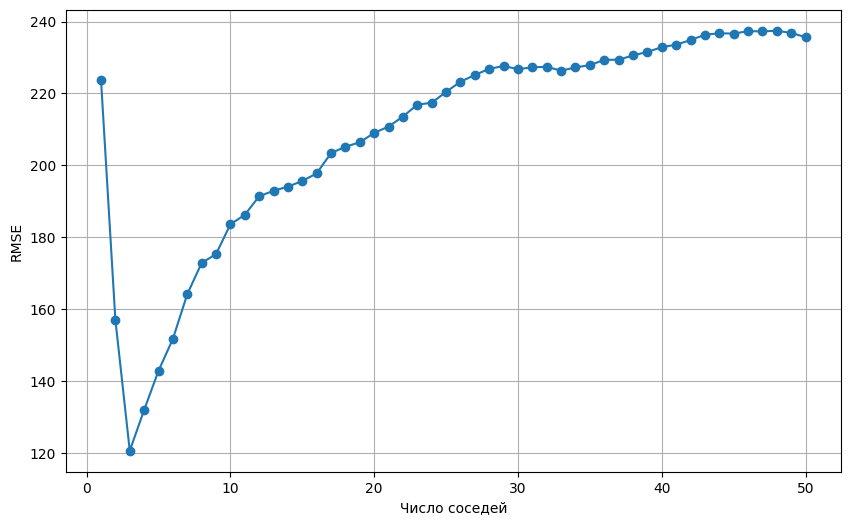

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('DAYTON_MW', axis=1))

X = scaled_features[:500]
y = df['DAYTON_MW'].values[:500]

def minkowski_distance(a, b, p):
    return np.sum(abs(a - b) ** p) **  (1 / p)

def knn_predict(X_train, y_train, X_test, k, p):
    regressor = KNeighborsRegressor(n_neighbors=k, metric=lambda a, b: minkowski_distance(a, b, p))
    regressor.fit(X_train, y_train)
    return regressor.predict(X_test)

def plot_knn_RMSE(min_neighbors, max_neighbors, step, x_test_set, y_test_set, p):
    neighbors = np.arange(min_neighbors, max_neighbors+1, step)
    losses = []

    for neighbor in tqdm(neighbors):  
        y_pred = knn_predict(X_train, y_train, x_test_set, neighbor, p)
        loss = mean_squared_error(y_test_set, y_pred, squared=False)  # RMSE
        losses.append(loss)

    plt.figure(figsize=(10, 6))
    plt.plot(neighbors, losses, marker='o', linestyle='-')
    plt.grid(True)
    plt.xlabel('Число соседей')
    plt.ylabel('RMSE')
    plt.show()

best_p = 5.37293098095798 
best_k = 87

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plot_knn_RMSE(1, 50, 1, X_test, y_test, best_p)


In [52]:
def knn_for_lowess(u, x_train, y_train, k, metric, kernel):
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
    nn.fit(x_train)
    distances, indices = nn.kneighbors([u])
    kth_distance = distances[0][-1]
    
    classes = np.unique(y_train)
    class_votes = {c: 0 for c in classes}
    for i in indices[0]:
        if np.array_equal(x_train[i, :], u):
            continue
        weight = kernel(metric(u, x_train[i, :]) / kth_distance)
        class_votes[y_train[i]] += weight

    return max(class_votes, key=class_votes.get)

def epanechnikov_kernel(x):
    return np.where(np.abs(x) <= np.sqrt(5), 3/4*(1 - x**2/5), 0)

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

random_index = np.random.choice(X_train.shape[0])
random_point = X_train[random_index]

predicted_class = knn_for_lowess(random_point, X_train, y_train, best_k, euclidean_distance, epanechnikov_kernel)

print(f"Значение случайной точки: {random_point}")
print(f"Предсказанный класс: {predicted_class}")



Значение случайной точки: [-1.78752807  1.58883003  1.39475487 -1.22823084]
Предсказанный класс: 1929.0


In [65]:
import numpy as np
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import normalize
from scipy.spatial import distance_matrix

def calculate_weights(X):
    dist_matrix = distance_matrix(X, X)
    weights = []
    for dist in dist_matrix:
        weights.append(np.reciprocal(np.sort(dist)[1:4]))
    weights = normalize(np.array(weights), norm='l1')
    return weights

weights = calculate_weights(X_train)

X_train_weighted = np.repeat(X_train, np.round(weights.mean(axis=1)*10).astype(int), axis=0)
y_train_weighted = np.repeat(y_train, np.round(weights.mean(axis=1)*10).astype(int), axis=0)

knn_weighted = KNeighborsClassifier(n_neighbors=3)
knn_weighted.fit(X_train_weighted, y_train_weighted)

print("Score with weighted training set:", knn_weighted.score(X_test, y_test))
# получили что метод lowess не применим в данной ситуации:(

Score with weighted training set: 0.0
